# Experimentación

In [1]:
import copy
import numpy as np
import pandas as pd
from junifer.storage import HDF5FeatureStorage
import julearn
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging

from julearn.model_selection import RepeatedContinuousStratifiedKFold

configure_logging(level="INFO")

2024-06-06 16:59:22,700 - julearn - INFO - ===== Lib Versions =====
2024-06-06 16:59:22,701 - julearn - INFO - numpy: 1.26.4
2024-06-06 16:59:22,702 - julearn - INFO - scipy: 1.11.4
2024-06-06 16:59:22,703 - julearn - INFO - sklearn: 1.3.2
2024-06-06 16:59:22,704 - julearn - INFO - pandas: 2.2.1
2024-06-06 16:59:22,706 - julearn - INFO - julearn: 0.3.2
2024-06-06 16:59:22,707 - julearn - INFO - ========================


In [2]:
storage = HDF5FeatureStorage("./features/ds003097_GMD/ds003097_GMD.hdf5")

In [3]:
storage.list_features()

{'881ac4e46fc343c867f102ceb674fdff': {'datagrabber': {'class': 'PatternDataladDataGrabber',
   'patterns': {'VBM_GM': {'pattern': 'derivatives/fmriprep/{subject}/anat/{subject}_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz',
     'space': 'MNI152NLin2009cAsym'}},
   'replacements': ['subject'],
   'confounds_format': None,
   'types': ['VBM_GM'],
   'uri': 'https://github.com/OpenNeuroDatasets/ds003097.git',
   'datalad_dirty': False,
   'datalad_commit_id': '47f030747dbaf492acd9f9624528aef8d51d8bd9',
   'datalad_id': 'aefe5438-e93b-11ea-ad4c-8e2245da6db7'},
  'dependencies': {'nilearn': '0.10.2', 'numpy': '1.26.4'},
  'datareader': {'class': 'DefaultDataReader'},
  'type': 'VBM_GM',
  'marker': {'class': 'ParcelAggregation',
   'parcellation': ['Schaefer400x7'],
   'method': 'mean',
   'method_params': {},
   'masks': None,
   'name': 'Schaefer400x7_Mean',
   'time_method': None,
   'time_method_params': {}},
  '_element_keys': ['subject'],
  'name': 'VBM_GM_Schaefer400x7_Mean'},


In [4]:
# Cragando dataframe
df = storage.read_df("VBM_GM_Schaefer400x7_Mean")

In [5]:
# Cambiando etiquetas de las columnas
df_demografics = pd.read_csv("./data/participants.tsv", sep="\t")
df_demografics.rename(columns={"participant_id": "subject"}, inplace=True)

In [6]:
# Limpiando dataset
df.columns = df.columns.astype("str")
X = list(df.columns)
df_full = df.merge(df_demografics, on="subject")
df_full.dropna(inplace=True, subset=['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total'])
targets = ["IST_fluid", "IST_crystallised", "IST_memory"]

Separamos 10% de los datos para validación antes de entrenar los modelos

In [7]:
df_full.shape

(926, 431)

In [8]:
df_holdout = df_full.sample(frac=0.1, random_state=42)
df_holdout

,subject,LH_Vis_1,LH_Vis_2,LH_Vis_3,LH_Vis_4,LH_Vis_5,LH_Vis_6,LH_Vis_7,LH_Vis_8,LH_Vis_9,...,sexual_attraction_M,sexual_attraction_F,gender_identity_M,gender_identity_F,religious_upbringing,religious_now,religious_importance,DWI_TR_run1,DWI_TR_run2,DWI_TR_run3
324,sub-0232,0.595469,0.583046,0.574856,0.585874,0.568340,0.399556,0.425887,0.494309,0.448939,...,7.0,1.0,1.0,7.0,no,no,NaN,6.374,6.374,6.374
602,sub-0618,0.681815,0.623923,0.639983,0.633952,0.531099,0.509548,0.490886,0.496260,0.512260,...,1.0,7.0,7.0,1.0,yes,yes,2.0,6.311,6.311,6.311
30,sub-0088,0.613596,0.609324,0.593690,0.587286,0.557378,0.484507,0.388109,0.467534,0.467069,...,NaN,NaN,NaN,NaN,no,no,NaN,6.312,6.312,6.312
825,sub-0279,0.651182,0.600106,0.642439,0.618115,0.544233,0.496188,0.459722,0.494651,0.485733,...,4.0,4.0,1.0,7.0,yes,yes,3.0,6.374,6.374,6.374
295,sub-0117,0.630212,0.666502,0.539563,0.611556,0.499527,0.424214,0.465741,0.436535,0.462263,...,6.0,2.0,2.0,6.0,no,no,NaN,6.311,6.311,6.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,sub-0474,0.615340,0.523477,0.554569,0.561387,0.485375,0.367226,0.421650,0.420825,0.518794,...,1.0,7.0,7.0,1.0,no,no,NaN,6.733,6.733,6.733
60,sub-0568,0.605017,0.562343,0.575138,0.619175,0.572284,0.493328,0.478022,0.421056,0.448148,...,NaN,NaN,NaN,NaN,no,no,NaN,6.311,6.312,6.312
803,sub-0292,0.658658,0.597419,0.601469,0.540612,0.488542,0.496021,0.518156,0.458367,0.455227,...,7.0,1.0,1.0,7.0,no,no,NaN,6.311,6.311,6.311
660,sub-0613,0.599169,0.508107,0.547732,0.542647,0.497193,0.458906,0.472711,0.380681,0.472207,...,NaN,NaN,NaN,NaN,yes,yes,2.0,6.312,6.312,6.312


In [9]:
# Separando holdset de training set
df_full.drop(df_holdout.index, inplace=True)
df_full.shape

(833, 431)

### Correlación entre los targets

<Axes: >

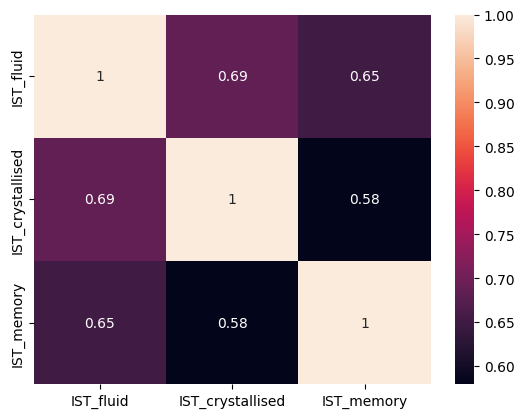

In [10]:
#correlation map of the 3 features to predict. IST_fluid, IST_crystallised, IST_memory and the total
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_full[targets].corr(), annot=True)

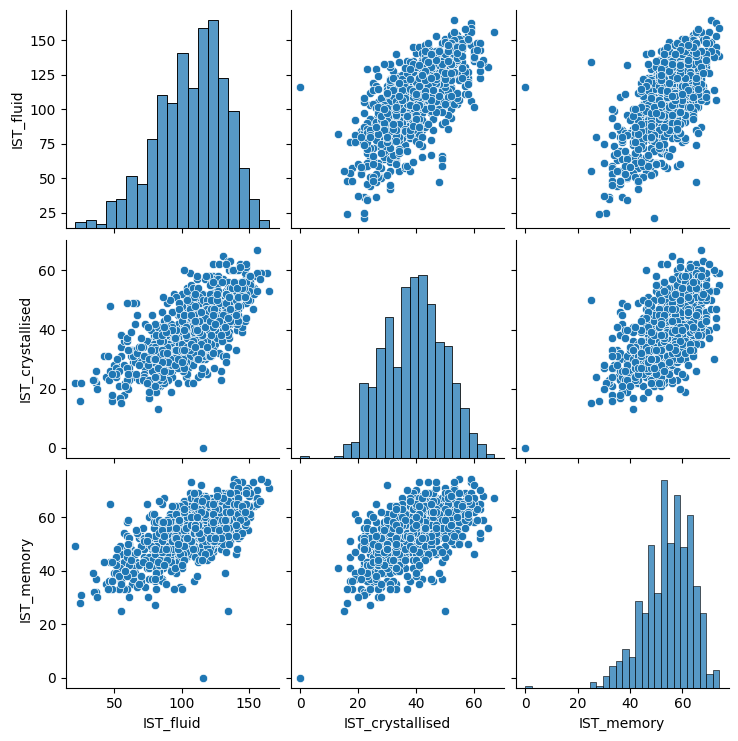

In [11]:
# Pairplot of the 3 features to predict. Correlation and distribution of the targets and the total

sns.pairplot(df_full[["IST_fluid", "IST_crystallised", "IST_memory", "IST_intelligence_total"]])

### Entrenamiento

In [12]:
cv = RepeatedContinuousStratifiedKFold(3, n_splits=3, n_repeats=10, random_state=42)

In [13]:
search_params = {
    "kind": "bayes",
    "n_iter": 50,
}

# Model 1 (SVM)
creator1 = PipelineCreator(problem_type="regression")
creator1.add("zscore")
creator1.add("svm",
             kernel="linear",
             C=(1e-6, 1, "log-uniform"),
             epsilon=(0.01, 3, "log-uniform")
            )

creator2 = PipelineCreator(problem_type="regression")
creator2.add("zscore")
creator2.add("svm", 
             kernel=["rbf", "sigmoid"],
             C=(1e-6, 1, "log-uniform"),
             gamma=[1e-5, 1e-4, 1e-3, 1e-2, "scale", "auto"],
             epsilon=(0.01, 3, "log-uniform")
            )

# Model 2 (Random Forest)
creator3 = PipelineCreator(problem_type="regression")
creator3.add("zscore")
creator3.add("rf", n_estimators=[25, 50, 100], max_depth=[5, 10, 20])

# Model 3 (Gradient Boosting)
creatorXG = PipelineCreator(problem_type="regression")
creatorXG.add("zscore")
creatorXG.add("gradientboost", n_estimators=[25, 50, 100], max_depth=[3, 5, 10], random_state=42)

# Model 4 (Dummy)
dummy_creator = PipelineCreator(problem_type="regression")
dummy_creator.add("zscore")
dummy_creator.add("dummy")

2024-06-06 16:59:26,994 - julearn - INFO - Adding step zscore that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-06 16:59:26,996 - julearn - INFO - Step added
2024-06-06 16:59:26,997 - julearn - INFO - Adding step svm that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-06 16:59:26,998 - julearn - INFO - Setting hyperparameter kernel = linear
2024-06-06 16:59:26,999 - julearn - INFO - Tuning hyperparameter C = (1e-06, 1, 'log-uniform')
2024-06-06 16:59:26,999 - julearn - INFO - Tuning hyperparameter epsilon = (0.01, 3, 'log-uniform')
2024-06-06 16:59:27,001 - julearn - INFO - Step added
2024-06-06 16:59:27,002 - julearn - INFO - Adding step zscore that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-06 16:59:27,006 - julearn - INFO - Step added
2024-06-06 16:59:27,008 - julearn - INFO - Adding step svm that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:typ

In [14]:
scores_dict = {t: {} for t in targets}
model_dict = {t: {} for t in targets}
inspector_dict = {t: {} for t in targets}

models = {'SVM': [creator1, creator2], 'RF': creator3, 'XGBoost': creatorXG, 'Dummy': dummy_creator}

### Visualización

In [15]:
from julearn.viz import plot_scores

In [16]:
for y in targets:
    for m_name, m in models.items():
        scores, model, inspector = run_cross_validation(
            X=X,
            y=y,
            data=df_full,
            model= m,
            return_train_score=True,
            return_inspector=True,
            cv=cv,
            scoring="neg_mean_absolute_error",
            search_params=search_params if m_name == "SVM" else None,
        )
        scores['model'] = m_name
        scores_dict[y][m_name] = scores.copy()
        model_dict[y][m_name] = copy.deepcopy(model)
        inspector_dict[y][m_name] = copy.deepcopy(inspector)

2024-06-06 16:59:28,996 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-06 16:59:28,998 - julearn - INFO - ==== Input Data ====
2024-06-06 16:59:28,999 - julearn - INFO - Using dataframe as input
2024-06-06 16:59:29,000 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-06 16:59:29,059 - julearn - INFO - ====================
2024-06-06 16:59:29,060 - julearn - INFO - 
2024-06-06 16:59:29,063 - julearn - INFO - = Model Parameters =
2024-06-06 16:59:29,064 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-06 16:59:29,066 - julearn - INFO - Hyperparameters:
2024-06-06 16:59:29,067 - julearn - INFO - 	svm__C: (1e-06, 1, 'log-uniform')
2024-06-06 16:59:29,068 - julearn - INFO - 	svm__epsilon: (0.01, 3, 'log-uniform')
2024-06-06 16:59:29,069 - julearn - INFO - Hyperparameter svm__C as is (1e-06, 1, 'log-uniform')
2024-06-06 16:59:29,070 - julearn - INFO - Hyperparameter svm__epsilon as is (0.01, 3, 'log-uniform')
2024-06-06 16:59:29,072 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 16:59:29,073 - julearn - INFO - Search Parameters:
2024-06-06 16:59:29,074 - julearn - INFO - 	n_iter: 50
2024-06-06 16:59:29,076 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=Fal

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.00033190395821123284, 0.015888527951405437, 1e-05, 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.0001193909343940751, 0.013802478436797999, 0.0001, 'sigmoid', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf',

2024-06-06 18:17:41,726 - julearn - INFO - Fitting final model
2024-06-06 18:20:06,167 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-06 18:20:06,168 - julearn - INFO - ==== Input Data ====
2024-06-06 18:20:06,169 - julearn - INFO - Using dataframe as input
2024-06-06 18:20:06,170 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17'

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-06 18:20:06,234 - julearn - INFO - ====================
2024-06-06 18:20:06,235 - julearn - INFO - 
2024-06-06 18:20:06,236 - julearn - INFO - = Model Parameters =
2024-06-06 18:20:06,238 - julearn - INFO - Tuning hyperparameters using grid
2024-06-06 18:20:06,239 - julearn - INFO - Hyperparameters:
2024-06-06 18:20:06,240 - julearn - INFO - 	rf__n_estimators: [25, 50, 100]
2024-06-06 18:20:06,241 - julearn - INFO - 	rf__max_depth: [5, 10, 20]
2024-06-06 18:20:06,243 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 18:20:06,244 - julearn - INFO - Search Parameters:
2024-06-06 18:20:06,245 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 18:20:06,246 - julearn - INFO - ====================
2024-06-06 18:20:06,248 - julearn - INFO - 
2024-06-06 18:20:06,249 - julearn - INFO - = Data Information =
2024-06-06 18:20:06,250 - julearn - INFO - 	Problem type: regression
2024-06-06 18:20:06,251 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-06 20:00:28,857 - julearn - INFO - ====================
2024-06-06 20:00:28,858 - julearn - INFO - 
2024-06-06 20:00:28,861 - julearn - INFO - = Model Parameters =
2024-06-06 20:00:28,861 - julearn - INFO - Tuning hyperparameters using grid
2024-06-06 20:00:28,862 - julearn - INFO - Hyperparameters:
2024-06-06 20:00:28,863 - julearn - INFO - 	gradientboost__n_estimators: [25, 50, 100]
2024-06-06 20:00:28,864 - julearn - INFO - 	gradientboost__max_depth: [3, 5, 10]
2024-06-06 20:00:28,865 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 20:00:28,866 - julearn - INFO - Search Parameters:
2024-06-06 20:00:28,867 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 20:00:28,868 - julearn - INFO - ====================
2024-06-06 20:00:28,868 - julearn - INFO - 
2024-06-06 20:00:28,869 - julearn - INFO - = Data Information =
2024-06-06 20:00:28,870 - julearn - INFO - 	Problem type: regression
202

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-06 21:44:30,009 - julearn - INFO - ====================
2024-06-06 21:44:30,009 - julearn - INFO - 
2024-06-06 21:44:30,011 - julearn - INFO - = Model Parameters =
2024-06-06 21:44:30,012 - julearn - INFO - ====================
2024-06-06 21:44:30,013 - julearn - INFO - 
2024-06-06 21:44:30,014 - julearn - INFO - = Data Information =
2024-06-06 21:44:30,015 - julearn - INFO - 	Problem type: regression
2024-06-06 21:44:30,016 - julearn - INFO - 	Number of samples: 833
2024-06-06 21:44:30,017 - julearn - INFO - 	Number of features: 400
2024-06-06 21:44:30,018 - julearn - INFO - ====================
2024-06-06 21:44:30,019 - julearn - INFO - 
2024-06-06 21:44:30,020 - julearn - INFO - 	Target type: float64
2024-06-06 21:44:30,021 - julearn - INFO - Using outer CV scheme RepeatedContinuousStratifiedKFold(method='binning', n_bins=3, n_repeats=10,
                 n_splits=3, random_state=42)
2024-06-06 21:44:30,408 - julearn - INFO - Fitting final model
2024-06-06 21:44:30,417 - jul

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-06 21:44:30,457 - julearn - INFO - ====================
2024-06-06 21:44:30,458 - julearn - INFO - 
2024-06-06 21:44:30,460 - julearn - INFO - = Model Parameters =
2024-06-06 21:44:30,461 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-06 21:44:30,462 - julearn - INFO - Hyperparameters:
2024-06-06 21:44:30,463 - julearn - INFO - 	svm__C: (1e-06, 1, 'log-uniform')
2024-06-06 21:44:30,464 - julearn - INFO - 	svm__epsilon: (0.01, 3, 'log-uniform')
2024-06-06 21:44:30,465 - julearn - INFO - Hyperparameter svm__C as is (1e-06, 1, 'log-uniform')
2024-06-06 21:44:30,466 - julearn - INFO - Hyperparameter svm__epsilon as is (0.01, 3, 'log-uniform')
2024-06-06 21:44:30,467 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 21:44:30,468 - julearn - INFO - Search Parameters:
2024-06-06 21:44:30,469 - julearn - INFO - 	n_iter: 50
2024-06-06 21:44:30,470 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=Fal

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.023313589585750125, 0.04177626576889092, 1e-05, 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 4.579437204614114e-06, 0.06695143198289714, 1e-05, 'sigmoid', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', Stan

2024-06-06 22:52:39,676 - julearn - INFO - Fitting final model


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 5.323395010769263e-06, 0.2947552213464662, 'auto', 'sigmoid', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.0007061606082598837, 2.1010110884638236, 0.01, 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', Stand

2024-06-06 22:55:07,954 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-06 22:55:07,955 - julearn - INFO - ==== Input Data ====
2024-06-06 22:55:07,956 - julearn - INFO - Using dataframe as input
2024-06-06 22:55:07,956 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-06 22:55:07,992 - julearn - INFO - ====================
2024-06-06 22:55:07,993 - julearn - INFO - 
2024-06-06 22:55:07,995 - julearn - INFO - = Model Parameters =
2024-06-06 22:55:07,995 - julearn - INFO - Tuning hyperparameters using grid
2024-06-06 22:55:07,996 - julearn - INFO - Hyperparameters:
2024-06-06 22:55:07,997 - julearn - INFO - 	rf__n_estimators: [25, 50, 100]
2024-06-06 22:55:07,998 - julearn - INFO - 	rf__max_depth: [5, 10, 20]
2024-06-06 22:55:07,999 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 22:55:08,000 - julearn - INFO - Search Parameters:
2024-06-06 22:55:08,001 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-06 22:55:08,002 - julearn - INFO - ====================
2024-06-06 22:55:08,002 - julearn - INFO - 
2024-06-06 22:55:08,003 - julearn - INFO - = Data Information =
2024-06-06 22:55:08,004 - julearn - INFO - 	Problem type: regression
2024-06-06 22:55:08,005 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-07 00:25:58,288 - julearn - INFO - ====================
2024-06-07 00:25:58,289 - julearn - INFO - 
2024-06-07 00:25:58,291 - julearn - INFO - = Model Parameters =
2024-06-07 00:25:58,291 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 00:25:58,292 - julearn - INFO - Hyperparameters:
2024-06-07 00:25:58,293 - julearn - INFO - 	gradientboost__n_estimators: [25, 50, 100]
2024-06-07 00:25:58,294 - julearn - INFO - 	gradientboost__max_depth: [3, 5, 10]
2024-06-07 00:25:58,295 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 00:25:58,296 - julearn - INFO - Search Parameters:
2024-06-07 00:25:58,297 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 00:25:58,298 - julearn - INFO - ====================
2024-06-07 00:25:58,299 - julearn - INFO - 
2024-06-07 00:25:58,299 - julearn - INFO - = Data Information =
2024-06-07 00:25:58,300 - julearn - INFO - 	Problem type: regression
202

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-07 02:17:11,244 - julearn - INFO - ====================
2024-06-07 02:17:11,245 - julearn - INFO - 
2024-06-07 02:17:11,250 - julearn - INFO - = Model Parameters =
2024-06-07 02:17:11,251 - julearn - INFO - ====================
2024-06-07 02:17:11,252 - julearn - INFO - 
2024-06-07 02:17:11,253 - julearn - INFO - = Data Information =
2024-06-07 02:17:11,255 - julearn - INFO - 	Problem type: regression
2024-06-07 02:17:11,256 - julearn - INFO - 	Number of samples: 833
2024-06-07 02:17:11,258 - julearn - INFO - 	Number of features: 400
2024-06-07 02:17:11,259 - julearn - INFO - ====================
2024-06-07 02:17:11,260 - julearn - INFO - 
2024-06-07 02:17:11,262 - julearn - INFO - 	Target type: float64
2024-06-07 02:17:11,264 - julearn - INFO - Using outer CV scheme RepeatedContinuousStratifiedKFold(method='binning', n_bins=3, n_repeats=10,
                 n_splits=3, random_state=42)
2024-06-07 02:17:11,879 - julearn - INFO - Fitting final model
2024-06-07 02:17:11,941 - jul

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-07 02:17:12,073 - julearn - INFO - ====================
2024-06-07 02:17:12,074 - julearn - INFO - 
2024-06-07 02:17:12,084 - julearn - INFO - = Model Parameters =
2024-06-07 02:17:12,086 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-07 02:17:12,089 - julearn - INFO - Hyperparameters:
2024-06-07 02:17:12,091 - julearn - INFO - 	svm__C: (1e-06, 1, 'log-uniform')
2024-06-07 02:17:12,092 - julearn - INFO - 	svm__epsilon: (0.01, 3, 'log-uniform')
2024-06-07 02:17:12,093 - julearn - INFO - Hyperparameter svm__C as is (1e-06, 1, 'log-uniform')
2024-06-07 02:17:12,095 - julearn - INFO - Hyperparameter svm__epsilon as is (0.01, 3, 'log-uniform')
2024-06-07 02:17:12,097 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 02:17:12,099 - julearn - INFO - Search Parameters:
2024-06-07 02:17:12,099 - julearn - INFO - 	n_iter: 50
2024-06-07 02:17:12,101 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=Fal

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been e

2024-06-07 04:28:50,639 - julearn - INFO - Fitting final model
2024-06-07 04:34:09,497 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-07 04:34:09,499 - julearn - INFO - ==== Input Data ====
2024-06-07 04:34:09,500 - julearn - INFO - Using dataframe as input
2024-06-07 04:34:09,501 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17'

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-07 04:34:09,554 - julearn - INFO - ====================
2024-06-07 04:34:09,555 - julearn - INFO - 
2024-06-07 04:34:09,558 - julearn - INFO - = Model Parameters =
2024-06-07 04:34:09,559 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 04:34:09,560 - julearn - INFO - Hyperparameters:
2024-06-07 04:34:09,561 - julearn - INFO - 	rf__n_estimators: [25, 50, 100]
2024-06-07 04:34:09,562 - julearn - INFO - 	rf__max_depth: [5, 10, 20]
2024-06-07 04:34:09,564 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 04:34:09,565 - julearn - INFO - Search Parameters:
2024-06-07 04:34:09,566 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 04:34:09,568 - julearn - INFO - ====================
2024-06-07 04:34:09,569 - julearn - INFO - 
2024-06-07 04:34:09,570 - julearn - INFO - = Data Information =
2024-06-07 04:34:09,571 - julearn - INFO - 	Problem type: regression
2024-06-07 04:34:09,572 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated

2024-06-07 06:16:25,659 - julearn - INFO - Fitting final model
2024-06-07 06:22:09,027 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-07 06:22:09,030 - julearn - INFO - ==== Input Data ====
2024-06-07 06:22:09,031 - julearn - INFO - Using dataframe as input
2024-06-07 06:22:09,033 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17'

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-07 06:22:09,116 - julearn - INFO - ====================
2024-06-07 06:22:09,118 - julearn - INFO - 
2024-06-07 06:22:09,125 - julearn - INFO - = Model Parameters =
2024-06-07 06:22:09,127 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 06:22:09,128 - julearn - INFO - Hyperparameters:
2024-06-07 06:22:09,129 - julearn - INFO - 	gradientboost__n_estimators: [25, 50, 100]
2024-06-07 06:22:09,131 - julearn - INFO - 	gradientboost__max_depth: [3, 5, 10]
2024-06-07 06:22:09,133 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 06:22:09,135 - julearn - INFO - Search Parameters:
2024-06-07 06:22:09,137 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 06:22:09,138 - julearn - INFO - ====================
2024-06-07 06:22:09,140 - julearn - INFO - 
2024-06-07 06:22:09,142 - julearn - INFO - = Data Information =
2024-06-07 06:22:09,143 - julearn - INFO - 	Problem type: regression
202

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated

2024-06-07 08:14:54,709 - julearn - INFO - Fitting final model
2024-06-07 08:20:57,424 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-07 08:20:57,426 - julearn - INFO - ==== Input Data ====
2024-06-07 08:20:57,427 - julearn - INFO - Using dataframe as input
2024-06-07 08:20:57,430 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17'

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-07 08:20:57,520 - julearn - INFO - ====================
2024-06-07 08:20:57,522 - julearn - INFO - 
2024-06-07 08:20:57,529 - julearn - INFO - = Model Parameters =
2024-06-07 08:20:57,531 - julearn - INFO - ====================
2024-06-07 08:20:57,533 - julearn - INFO - 
2024-06-07 08:20:57,535 - julearn - INFO - = Data Information =
2024-06-07 08:20:57,537 - julearn - INFO - 	Problem type: regression
2024-06-07 08:20:57,540 - julearn - INFO - 	Number of samples: 833
2024-06-07 08:20:57,541 - julearn - INFO - 	Number of features: 400
2024-06-07 08:20:57,543 - julearn - INFO - ====================
2024-06-07 08:20:57,545 - julearn - INFO - 
2024-06-07 08:20:57,547 - julearn - INFO - 	Target type: float64
2024-06-07 08:20:57,550 - julearn - INFO - Using outer CV scheme RepeatedContinuousStratifiedKFold(method='binning', n_bins=3, n_repeats=10,
                 n_splits=3, random_state=42)


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated

2024-06-07 08:20:58,381 - julearn - INFO - Fitting final model


In [17]:
for y in targets:
    for est in scores_dict[y]['SVM'].estimator:
        print("=================== " + y + " ======================")
        display(est.best_params_)

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.0002139471856787903),
             ('svm__epsilon', 1.0089383629158484),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 3.0),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.002946361075266825),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006294742084645081),
             ('svm__epsilon', 0.4191852956529042),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.002851672085492128),
             ('svm__epsilon', 0.011895390854472488),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 1e-06),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 3.0),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00127016008641538),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.008072864636680176),
             ('svm__epsilon', 0.044009375579057916),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0012255256211370098),
             ('svm__epsilon', 0.062366307702932534),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00744970593155115),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0031895735933997415),
             ('svm__epsilon', 0.010476452657053091),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 1.0557647332206568),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.13586877747439452),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00721028182867485),
             ('svm__epsilon', 2.3027635897309207),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.49842829834287644),
             ('svm__epsilon', 0.18904921988148804),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006295137854205856),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005150230960273902),
             ('svm__epsilon', 0.11994471776354339),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006816459944482341),
             ('svm__epsilon', 0.010702851407589451),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0017615118252019646),
             ('svm__epsilon', 0.011934516974837888),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.007670429559096373),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.40121677019952173),
             ('svm__epsilon', 0.013671746099904881),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 3.0),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0056219988730971055),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1e-06),
             ('svm__epsilon', 1.4991131375589017),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.023635452674873436),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005254351582866325),
             ('svm__epsilon', 0.011573604645693044),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.7715428021638749),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0034696476920698977),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0015101363639712661),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0044062016071414615),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0036949357840589205),
             ('svm__epsilon', 0.012060467439242677),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.003556933104960415),
             ('svm__epsilon', 1.5804381630274165),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005240246084583811),
             ('svm__epsilon', 1.9160648250983467),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.1134308840477237),
             ('svm__epsilon', 0.01719034414609727),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0063147782297047084),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004100498358626064),
             ('svm__epsilon', 2.6084455208052297),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004138389223197703),
             ('svm__epsilon', 2.26181380646228),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004500781571611451),
             ('svm__epsilon', 0.04626638496466679),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0020024419020770847),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.003053578401167835),
             ('svm__epsilon', 0.06931952939111923),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004068691581099717),
             ('svm__epsilon', 2.545870420617208),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004381465124193229),
             ('svm__epsilon', 2.871070115218701),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.003092887653119296),
             ('svm__epsilon', 0.013086962387956086),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0046584336345921315),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.18786656243356095),
             ('svm__epsilon', 0.04727088923992266),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006224348018692678),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.9792774945194327),
             ('svm__epsilon', 0.44380852717612634),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0032901107941066938),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004534875261565196),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.002614178104426358),
             ('svm__epsilon', 2.0693817563530663),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.007129008952986566),
             ('svm__epsilon', 2.7705212502315275),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0024866585499381507),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.32262380771371096),
             ('svm__epsilon', 0.3859363255344005),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005965489767086874),
             ('svm__epsilon', 2.123513302833605),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.003700308974494643),
             ('svm__epsilon', 2.895465763723168),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005829565544263063),
             ('svm__epsilon', 2.865121518116528),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0015917535576878093),
             ('svm__epsilon', 0.015561518465776766),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.9422624218976423),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00215975520065313),
             ('svm__epsilon', 1.7868420074984295),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006533756648094139),
             ('svm__epsilon', 1.7643364406962738),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0004000451438631881),
             ('svm__epsilon', 2.920092234999561),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.09658249582783773),
             ('svm__epsilon', 2.5781670959144987),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.779867300233172),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0003713961378903401),
             ('svm__epsilon', 0.011852069312173098),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.06845261701073264),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.5482757298686648),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0009909844667314101),
             ('svm__epsilon', 0.011343601695996927),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.013220970026489547),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1e-06),
             ('svm__epsilon', 0.5201189488221356),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 3.0),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.001212155053915454),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.6266167650206309),
             ('svm__epsilon', 0.1596280777746199),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0005015203545920148),
             ('svm__epsilon', 0.01368947159167481),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0002745757496591585),
             ('svm__epsilon', 0.45663531282998077),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.4982674249788851),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.46711737071795856),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0011541869200241957),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.9101489766759646),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.8089624026731728),
             ('svm__epsilon', 0.07101516774820027),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.7333706604928285),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 2.887550802163245e-05),
             ('svm__epsilon', 1.9501210536549387),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 2.321973283685834),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.16995104783150297),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

In [18]:
for y in targets:
    s1, s2, s3, s4 = tuple(scores_dict[y].values())
    panel = plot_scores(s1, s2, s3, s4)
    panel.show()

Launching server at http://localhost:40375


Launching server at http://localhost:41117


Launching server at http://localhost:37127


2024-06-07 16:38:09,355 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,361 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,385 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,388 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,395 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,401 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,408 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,415 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,422 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,431 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,439 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:09,442 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,796 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,798 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,805 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,807 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,815 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,818 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,827 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,830 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,836 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,839 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,846 - julearn - WARNING - The training set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:175: RuntimeWarning: The training set sizes are not the same. Will use a rounded average.
  warn_with_log(


2024-06-07 16:38:10,848 - julearn - WARNING - The testing set sizes are not the same. Will use a rounded average.


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/stats/corrected_ttest.py:184: RuntimeWarning: The testing set sizes are not the same. Will use a rounded average.
  warn_with_log(


MAE SVM:  34.3644939940744
MAE RF:  34.41688366548633
MAE XGBoost:  33.870908855101156
MAE Dummy:  34.958886780518654


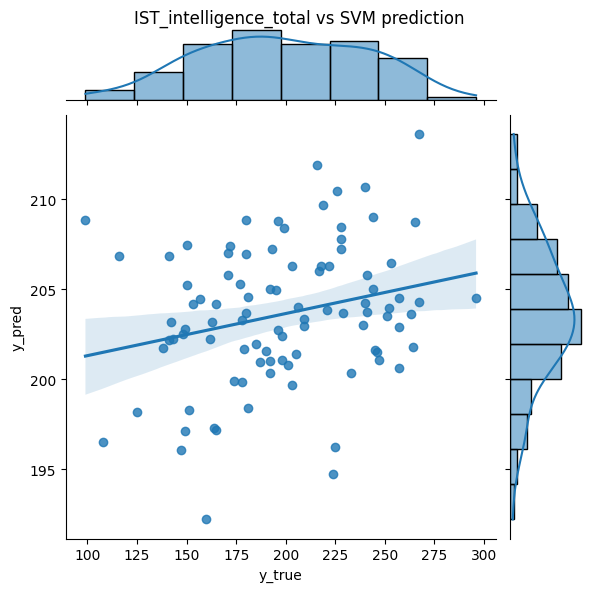

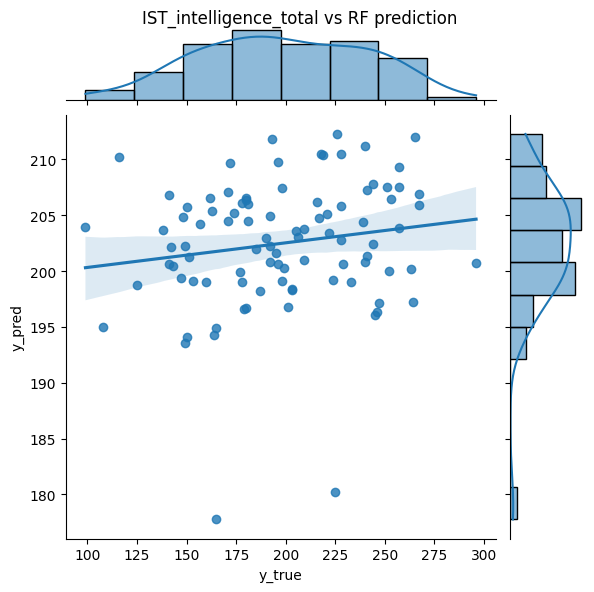

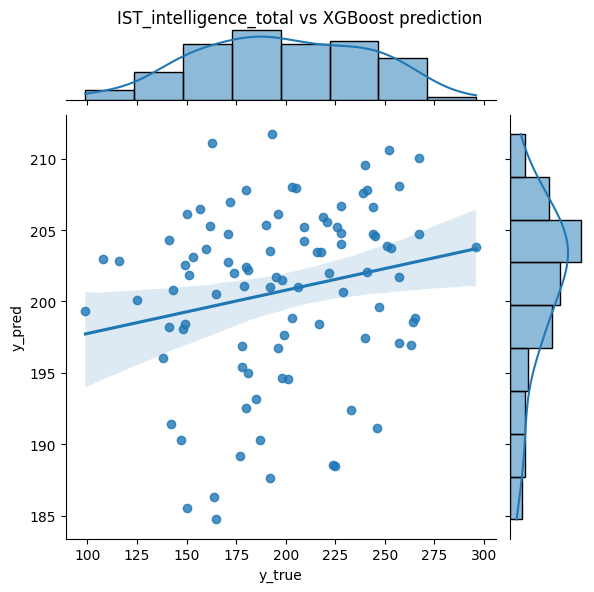

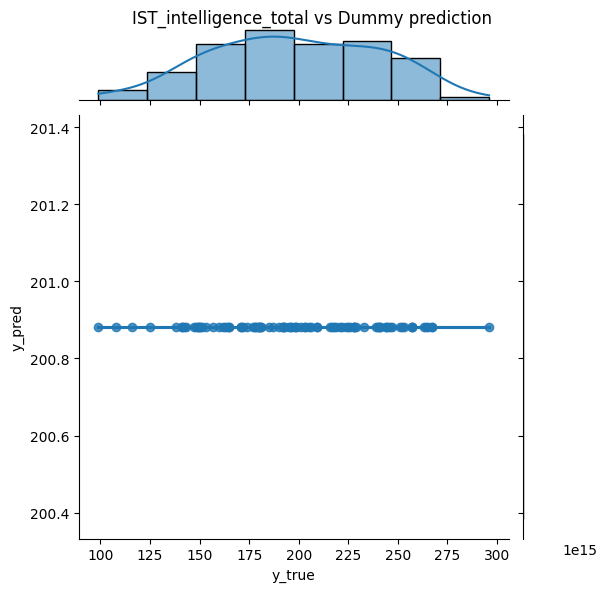

In [156]:
for i, m_name in enumerate(models.keys()):
    y_true = df_holdout['IST_intelligence_total']
    y_pred_fluid = model_dict['IST_fluid'][m_name].predict(df_holdout[X])
    y_pred_memory = model_dict['IST_memory'][m_name].predict(df_holdout[X])
    y_pred_crystallised = model_dict['IST_crystallised'][m_name].predict(df_holdout[X])

    y_pred = y_pred_fluid + y_pred_memory + y_pred_crystallised

    y_lim_min = min(min(y_pred), min(y_true))
    y_lim_max = max(max(y_pred), max(y_true))

    print(f'MAE {m_name}: ', np.mean(abs(y_pred - y_true)))

    df_plot = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    j = sns.jointplot(data=df_plot, x="y_true", y="y_pred", kind="reg")
    plt.suptitle(f'IST_intelligence_total vs {m_name} prediction')
    j.fig.subplots_adjust(top=0.95)
    j.savefig(f'./svg/Schaefer/IST_total_vs_{m_name}_pred.svg')

In [157]:
for target, score_by_model_for_target in scores_dict.items():
    for model_name, score_for_model in score_by_model_for_target.items():
        score_for_model.to_csv(f'./scores/Schaefer/{target}_{model_name}.csv')

In [155]:
for i, m_name in enumerate(models.keys()):
    y_true_fluid = df_holdout['IST_fluid']
    y_true_crystallised = df_holdout['IST_crystallised']
    y_true_memory = df_holdout['IST_memory']
    y_pred_fluid = model_dict['IST_fluid'][m_name].predict(df_holdout[X])
    y_pred_crystallised = model_dict['IST_crystallised'][m_name].predict(df_holdout[X])
    y_pred_memory = model_dict['IST_memory'][m_name].predict(df_holdout[X])

    y_mae_fluid = np.mean(abs(y_true_fluid - y_pred_fluid))
    y_mae_crystallised = np.mean(abs(y_true_crystallised - y_pred_crystallised))
    y_mae_memory = np.mean(abs(y_true_memory - y_pred_memory))

    np.savetxt(f"schaefer_{m_name}_y_pred_fluid.csv", y_pred_fluid, delimiter=",")
    np.savetxt(f"schaefer_{m_name}_y_pred_crystallised.csv", y_pred_crystallised, delimiter=",")
    np.savetxt(f"schaefer_{m_name}_y_pred_memory.csv", y_pred_memory, delimiter=",")
    y_true_fluid.to_csv('schaefer_y_true_fluid.csv')
    y_true_crystallised.to_csv('schaefer_y_true_crystallised.csv')
    y_true_memory.to_csv('schaefer_y_true_memory.csv')

    print(f'===================== {m_name} =====================')
    print(f'IST_fluid MAE for {m_name}: {y_mae_fluid}')
    print(f'IST_fluid mean_pred for {m_name}: {np.mean(y_pred_fluid)}')
    print(f'IST_fluid std_pred for {m_name}: {np.std(y_pred_fluid)}')
    print('------------------------------------------')
    print(f'IST_crystallised MAE for {m_name}: {y_mae_crystallised}')
    print(f'IST_crystallised mean_pred for {m_name}: {np.mean(y_pred_crystallised)}')
    print(f'IST_crystallised std_pred for {m_name}: {np.std(y_pred_crystallised)}')
    print('------------------------------------------')
    print(f'IST_memory MAE for {m_name}: {y_mae_memory}')
    print(f'IST_memory mean_pred for {m_name}: {np.mean(y_pred_memory)}')
    print(f'IST_memory std_pred for {m_name}: {np.std(y_pred_memory)}')

===================== SVM =====================
IST_fluid MAE for SVM: 22.561425688484363
IST_fluid mean_pred for SVM: 109.29963562854478
IST_fluid std_pred for SVM: 2.0756371248923857
------------------------------------------
IST_crystallised MAE for SVM: 8.812488402232113
IST_crystallised mean_pred for SVM: 39.25185728665781
IST_crystallised std_pred for SVM: 1.8529567329832302
------------------------------------------
IST_memory MAE for SVM: 7.061289465846607
IST_memory mean_pred for SVM: 55.061079734550496
IST_memory std_pred for SVM: 0.8267888602605745
===================== RF =====================
IST_fluid MAE for RF: 22.201062126250495
IST_fluid mean_pred for RF: 108.58130537427884
IST_fluid std_pred for RF: 3.756323824919998
------------------------------------------
IST_crystallised MAE for RF: 9.095191413117194
IST_crystallised mean_pred for RF: 39.40943086091882
IST_crystallised std_pred for RF: 1.7473084369366458
------------------------------------------
IST_memory MAE 

In [59]:
for y in targets:
    print(y)
    print(np.mean(df_full[y]))
    print(np.std(df_full[y]))

IST_fluid
107.13685474189676
25.683744667929048
IST_crystallised
39.30612244897959
10.167442022530771
IST_memory
54.43937575030012
9.177271658641617


In [48]:
df_holdout.to_csv('schaefer_holdout.csv')